# Testing the ReGene framework

If on Google Drive, set to true.

In [1]:
inDrive = True

## Setup


Load Drive

In [2]:
if inDrive:
    from google.colab import drive
    drive.mount('/content/drive')

    import os
    import sys

    os.chdir('/content/drive/MyDrive/Hybrid-CLUE/ReGene')
    current_dir = os.getcwd()
    parent_dir = os.path.abspath(os.path.join(current_dir, os.pardir))
    sys.path.append(parent_dir)

Mounted at /content/drive


Import libraries

In [3]:
import importlib
import regene_models
importlib.reload(regene_models)
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

Set the device

In [4]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

Load the Datasets

In [5]:
# Load the MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
trainset = torchvision.datasets.MNIST(root='../data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)

## Classifier

### Training

First we define the classifier

In [6]:
classifier = regene_models.Classifier(latent_dim=32, num_classes=10, device=device)

Then we train

In [7]:
classifier.train_classifier(trainloader, num_epochs=10, lr=0.001)

Epoch [1/10], Loss: 0.0729
Epoch [2/10], Loss: 0.0252
Epoch [3/10], Loss: 0.0118
Epoch [4/10], Loss: 0.0020
Epoch [5/10], Loss: 0.1709
Epoch [6/10], Loss: 0.1449
Epoch [7/10], Loss: 0.0294
Epoch [8/10], Loss: 0.0345
Epoch [9/10], Loss: 0.0014
Epoch [10/10], Loss: 0.0049


### Testing


First let's test the classifier on a few images

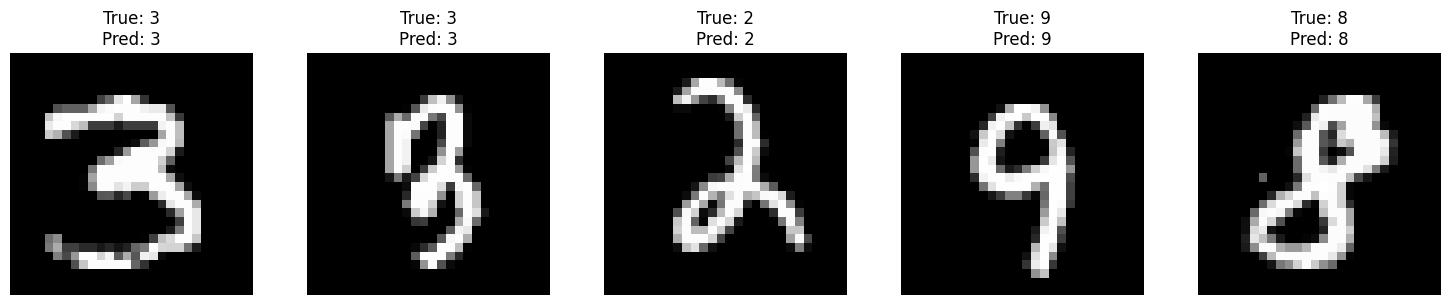

In [8]:
# Get random indices for test images
random_indices = torch.randint(0, len(trainset), (5,))
images = torch.stack([trainset[i][0] for i in random_indices])
labels = torch.tensor([trainset[i][1] for i in random_indices])

# Get predictions
classifier.eval()  # Set to evaluation mode
with torch.no_grad():
    images = images.to(device)
    _, predictions = classifier(images)
    predicted_classes = torch.argmax(predictions, dim=1)

# Plot images with true and predicted labels
plt.figure(figsize=(15, 3))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(images[i].cpu().squeeze().numpy(), cmap='gray')
    plt.title(f'True: {labels[i].item()}\nPred: {predicted_classes[i].cpu().item()}')
    plt.axis('off')

plt.tight_layout()
plt.show()


We'll also visualise the latent space. This is done by taking the latent representations of 50 training images and plotting them in 2D using t-SNE.

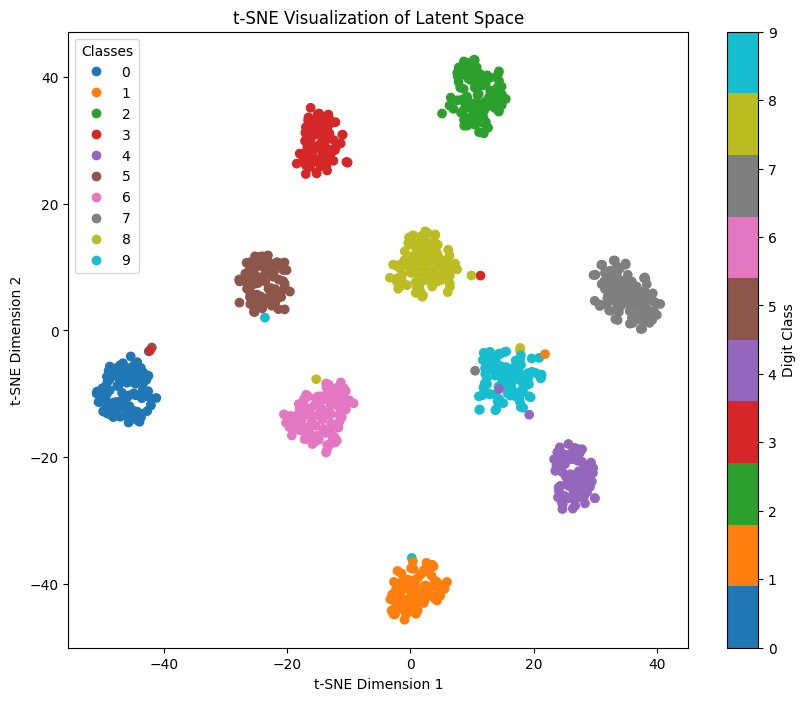

In [9]:
# Get latent representations for 50 random training images
random_indices = torch.randint(0, len(trainset), (1000,))
images = torch.stack([trainset[i][0] for i in random_indices])
labels = torch.tensor([trainset[i][1] for i in random_indices])

# Get latent representations
classifier.eval()
with torch.no_grad():
    images = images.to(device)
    latent_reps, _ = classifier(images)
    latent_reps = latent_reps.cpu().numpy()

# Perform t-SNE dimensionality reduction
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=42)
latent_2d = tsne.fit_transform(latent_reps)

# Plot the 2D latent space
plt.figure(figsize=(10, 8))
scatter = plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=labels, cmap='tab10')
plt.colorbar(scatter, label='Digit Class')
plt.title('t-SNE Visualization of Latent Space')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend(*scatter.legend_elements(), title="Classes")
plt.show()


## Decoder

### Training

We define the decoder, and then train it using the classifier's latent space.

In [10]:
decoder = regene_models.Decoder(latent_dim=32)

In [11]:
decoder.train_decoder(trainloader, classifier, num_epochs=50, lr=0.001)

Decoder Epoch [1/50], Loss: 0.8837
Decoder Epoch [2/50], Loss: 0.8804
Decoder Epoch [3/50], Loss: 0.8828
Decoder Epoch [4/50], Loss: 0.8849
Decoder Epoch [5/50], Loss: 0.8932
Decoder Epoch [6/50], Loss: 0.8732
Decoder Epoch [7/50], Loss: 0.8704
Decoder Epoch [8/50], Loss: 0.8788
Decoder Epoch [9/50], Loss: 0.8859
Decoder Epoch [10/50], Loss: 0.8777
Decoder Epoch [11/50], Loss: 0.8828
Decoder Epoch [12/50], Loss: 0.8812
Decoder Epoch [13/50], Loss: 0.8754
Decoder Epoch [14/50], Loss: 0.8785
Decoder Epoch [15/50], Loss: 0.8761
Decoder Epoch [16/50], Loss: 0.8649
Decoder Epoch [17/50], Loss: 0.8654
Decoder Epoch [18/50], Loss: 0.8708
Decoder Epoch [19/50], Loss: 0.8741
Decoder Epoch [20/50], Loss: 0.8763
Decoder Epoch [21/50], Loss: 0.8626
Decoder Epoch [22/50], Loss: 0.8803
Decoder Epoch [23/50], Loss: 0.8743
Decoder Epoch [24/50], Loss: 0.8546
Decoder Epoch [25/50], Loss: 0.8843
Decoder Epoch [26/50], Loss: 0.8787
Decoder Epoch [27/50], Loss: 0.8587
Decoder Epoch [28/50], Loss: 0.8775
D

### Testing


First less visualise some reconstructions

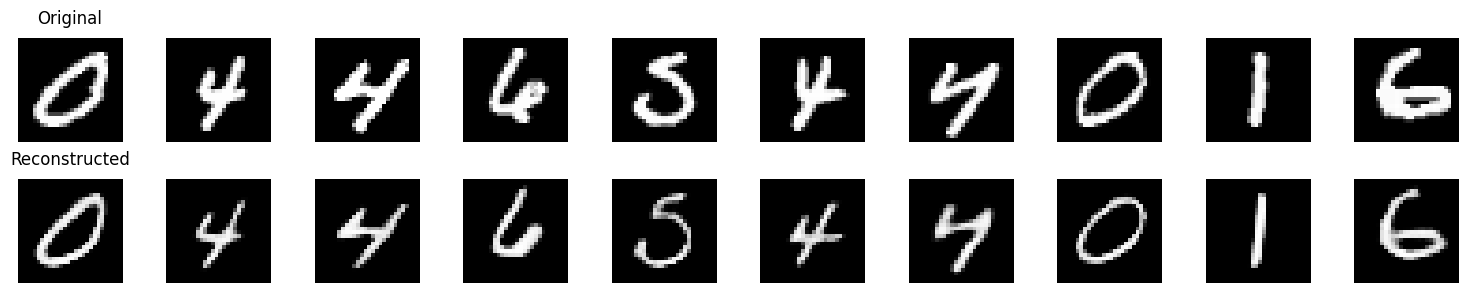

In [17]:
# Get 10 random images from training set
dataiter = iter(trainloader)
images, _ = next(dataiter)
images = images[:10]

# Get reconstructions
classifier.eval()
decoder.eval()
with torch.no_grad():
    z, _ = classifier(images)
    reconstructed = decoder(z)

# Plot original vs reconstructed images
fig, axes = plt.subplots(2, 10, figsize=(15, 3))
for i in range(10):
    # Original images
    axes[0,i].imshow(images[i].squeeze(), cmap='gray')
    axes[0,i].axis('off')
    if i == 0:
        axes[0,i].set_title('Original', pad=10)

    # Reconstructed images
    axes[1,i].imshow(reconstructed[i].squeeze(), cmap='gray')
    axes[1,i].axis('off')
    if i == 0:
        axes[1,i].set_title('Reconstructed', pad=10)

plt.tight_layout()
plt.show()
